# Opioid Mortality Rate
# 

In [4]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [5]:
# Reading the mortality dataset
pd.set_option("display.max_columns", None)

mortality_data = pd.read_csv(
    "https://raw.githubusercontent.com/MIDS-at-Duke/opioids-2024-optoid-drug-mortality-group5/refs/heads/main/01_Data/03_Results/mortality_population.csv?token=GHSAT0AAAAAACZHZQITMKRI5DIHIKSEVMM2Z2WLSDA"
)
mortality_data

,STATE_NAME,STATE,COUNTY,COUNTY_CODE,YEAR,POPULATION,DEATHS
0,COLORADO,CO,ADAMS COUNTY,8001,2003,377464,42
1,COLORADO,CO,ADAMS COUNTY,8001,2004,384809,46
2,COLORADO,CO,ADAMS COUNTY,8001,2005,395146,63
3,COLORADO,CO,ADAMS COUNTY,8001,2006,406575,62
4,COLORADO,CO,ADAMS COUNTY,8001,2007,415746,70
...,...,...,...,...,...,...,...
1823,WASHINGTON,WA,YAKIMA COUNTY,53077,2011,245899,14
1824,WASHINGTON,WA,YAKIMA COUNTY,53077,2012,245899,25
1825,WASHINGTON,WA,YAKIMA COUNTY,53077,2013,246064,14
1826,WASHINGTON,WA,YAKIMA COUNTY,53077,2014,246395,23


In [6]:
# Createing 'MORTALITY_DATA' column
mortality_data["MORTALITY_DATA"] = (
    mortality_data["DEATHS"] / mortality_data["POPULATION"]
)
mortality_data

,STATE_NAME,STATE,COUNTY,COUNTY_CODE,YEAR,POPULATION,DEATHS,MORTALITY_DATA
0,COLORADO,CO,ADAMS COUNTY,8001,2003,377464,42,0.000111
1,COLORADO,CO,ADAMS COUNTY,8001,2004,384809,46,0.000120
2,COLORADO,CO,ADAMS COUNTY,8001,2005,395146,63,0.000159
3,COLORADO,CO,ADAMS COUNTY,8001,2006,406575,62,0.000152
4,COLORADO,CO,ADAMS COUNTY,8001,2007,415746,70,0.000168
...,...,...,...,...,...,...,...,...
1823,WASHINGTON,WA,YAKIMA COUNTY,53077,2011,245899,14,0.000057
1824,WASHINGTON,WA,YAKIMA COUNTY,53077,2012,245899,25,0.000102
1825,WASHINGTON,WA,YAKIMA COUNTY,53077,2013,246064,14,0.000057
1826,WASHINGTON,WA,YAKIMA COUNTY,53077,2014,246395,23,0.000093


In [7]:
# Defining normalization factor in order to normalize 'Mortality_Rate' column
norm_mort_mult = 1000000

# Createing 'Norm_mort_mult' column in the dataframe by multiplying 'Mortality_Rate' by normalization factor
mortality_data["MORM_MORT_MULT"] = mortality_data["MORTALITY_DATA"] * norm_mort_mult

# Seting the label for the y-axis, formatted with the normalization factor
ylabels = f"Mortality per 1M people"
ylabels

'Mortality per 1M people'

In [8]:
mortality_data

,STATE_NAME,STATE,COUNTY,COUNTY_CODE,YEAR,POPULATION,DEATHS,MORTALITY_DATA,MORM_MORT_MULT
0,COLORADO,CO,ADAMS COUNTY,8001,2003,377464,42,0.000111,111.268889
1,COLORADO,CO,ADAMS COUNTY,8001,2004,384809,46,0.000120,119.539824
2,COLORADO,CO,ADAMS COUNTY,8001,2005,395146,63,0.000159,159.434741
3,COLORADO,CO,ADAMS COUNTY,8001,2006,406575,62,0.000152,152.493390
4,COLORADO,CO,ADAMS COUNTY,8001,2007,415746,70,0.000168,168.372035
...,...,...,...,...,...,...,...,...,...
1823,WASHINGTON,WA,YAKIMA COUNTY,53077,2011,245899,14,0.000057,56.933944
1824,WASHINGTON,WA,YAKIMA COUNTY,53077,2012,245899,25,0.000102,101.667758
1825,WASHINGTON,WA,YAKIMA COUNTY,53077,2013,246064,14,0.000057,56.895767
1826,WASHINGTON,WA,YAKIMA COUNTY,53077,2014,246395,23,0.000093,93.346050


In [9]:
def prepare_data(
    dataset,
    testing_state,
    controlling_states,
    pol_impl_year,
    starting_year,
    ending_year,
):
    """
    Parameters:
        dataset (DataFrame): The original dataset to be processed.
        testing_state (str): The state where the policy is implemented (Test state).
        controlling_states (list): List of control states for comparison.
        pol_impl_year (int): The year the policy was implemented.
        starting_year (int): The first year of the analysis period.
        ending_year (int): The last year of the analysis period.
    """

    # Combining test and control states to filter
    relevant_states = [testing_state] + controlling_states

    # Filtering the dataset based on the relevant states and years
    filtered_dataset = dataset[
        (dataset["STATE"].isin(relevant_states))
        & (dataset["YEAR"].between(starting_year, ending_year))
    ].copy()

    # Adding column indicating whether the policy is pre or post implementation
    filtered_dataset["POLICY_IMPLEMENTATION"] = (
        filtered_dataset["YEAR"] >= pol_impl_year
    )

    # Labelling each state as 'Test' or 'Control' based on the provided states
    filtered_dataset["STATE_TYPE"] = filtered_dataset["STATE"].apply(
        lambda state: "Test" if state == testing_state else "Control"
    )

    return filtered_dataset

In [10]:
def pre_post_plot(dataset_2, testing_state, pol_implem_year, metric_column):
    """
    Parameters:
        dataset_2 (DataFrame): The dataset to be visualized.
        metric_column (str): The column representing the metric to plot ("MORM_MORT_MULT").
    """

    # Creating a copy of the dataset to avoid modifying the original DataFrame
    dataset = dataset_2.copy()

    # Seting up the plot
    fig, ax = plt.subplots(figsize=(8, 4))

    # Defining the data for pre-policy and post-policy analysis
    pre_policy_data = dataset[
        (dataset["STATE"] == testing_state)
        & (dataset["POLICY_IMPLEMENTATION"] == False)
    ]
    post_policy_data = dataset[
        (dataset["STATE"] == testing_state) & (dataset["POLICY_IMPLEMENTATION"] == True)
    ]

    # Ploting pre-policy trend line
    sns.regplot(
        data=pre_policy_data,
        x="YEAR",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    # Ploting post-policy trend line
    sns.regplot(
        data=post_policy_data,
        x="YEAR",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    # Adding a vertical line at the policy implemented year
    ax.axvline(pol_implem_year, ls="--", color="black", label="Policy Implemented Year")

    # Defining the legend
    legend_handles = [
        mlines.Line2D([], [], color="red", label="Post-Policy period"),
        mlines.Line2D([], [], color="blue", label="Pre-Policy period"),
        mlines.Line2D(
            [], [], color="black", label="Policy Implemented Year", linestyle="--"
        ),
    ]
    ax.legend(handles=legend_handles, loc="lower right")

    # Adding titles and labels
    ax.set_title(f"Pre-Post Analysis for Mortality Rate: {testing_state}")
    ax.set_xlabel("Years")
    ax.set_ylabel(f"Mortality per 1M people")

    # Showing the plot
    plt.show()

In [ ]:
def dif_dif_plot(
    dataset_2, testing_state, controlling_state, pol_implem_year, metric_column
):

    # Creating a copy of the dataset to avoid modifying the original DataFrame
    dataset = dataset_2.copy()

    # Seting up the plot
    fig, ax = plt.subplots(figsize=(8.2, 4))

    # Filtering data for pre- and post-policy periods
    test_state_pre = dataset[
        (dataset["STATE"] == testing_state)
        & (dataset["POLICY_IMPLEMENTATION"] == False)
    ]
    test_state_post = dataset[
        (dataset["STATE"] == testing_state) & (dataset["POLICY_IMPLEMENTATION"] == True)
    ]
    control_states_pre = dataset[
        (dataset["STATE"].isin(controlling_state))
        & (dataset["POLICY_IMPLEMENTATION"] == False)
    ]
    control_states_post = dataset[
        (dataset["STATE"].isin(controlling_state))
        & (dataset["POLICY_IMPLEMENTATION"] == True)
    ]

    # Ploting difference-in-difference analysis for testing and controlling states
    sns.regplot(
        data=test_state_pre,
        x="YEAR",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )
    sns.regplot(
        data=test_state_post,
        x="YEAR",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )
    sns.regplot(
        data=control_states_pre,
        x="YEAR",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )
    sns.regplot(
        data=control_states_post,
        x="YEAR",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    # Adding a vertical line for the policy implementation year
    ax.axvline(pol_implem_year, ls="--", color="black", label="Policy Implemented Year")

    # Adding legend
    plt.legend(
        handles=[
            mlines.Line2D([], [], color="blue", label="Test State"),
            mlines.Line2D([], [], color="red", label="Control States (GA, NC, SC)"),
            mlines.Line2D(
                [],
                [],
                color="black",
                linestyle="--",
                label="Policy Implemented Year (2010)",
            ),
        ],
        loc="lower right",
    )

    # Seting titles and labels
    plt.title(f"Difference-in-Difference Analysis for Mortality Rate: {testing_state}")
    plt.xlabel("Years")
    plt.ylabel(f"Mortality per 1M people")

    # Adding a note below the plot
    fig.text(
        0.12,
        -0.12,
        "Note: The shaded regions represent 95% confidence intervals. "
        "The analysis compares mortality rates before and after the policy implementation year (2010) in Washington. "
        "Pre-policy data (2006-2009) and post-policy data (2010-2013) were used.",
        ha="left",
        fontsize=10,
        wrap=True,
    )

    # Showing plot
    plt.show()

In [12]:
def all_states_plot(dataset_2, pol_implem_year, metric_column, norm_mort_mult=1000000):

    # Creating a copy of the dataset to avoid modifying the original DataFrame
    dataset = dataset_2.copy()

    # Creating the lmplot for the dataset with state-wise breakdown
    plot = sns.lmplot(
        data=dataset,
        x="YEAR",
        y=metric_column,
        hue="POLICY_IMPLEMENTATION",
        legend=False,
        row="STATE",
        height=4,
        aspect=1.75,
    )

    # Seting titles for each subplot using the state names
    plot.set_titles("{row_name}", fontsize=12)

    # Adding a vertical line at the policy implementation year
    for ax in plot.axes.flat:
        ax.axvline(
            pol_implem_year,
            ls="--",
            color="black",
            lw=2,
            label="Policy Implementated Year",
        )

    plt.legend(
        loc="lower right",
        ncol=2,
    )

    ax = plot.axes[0, 0]

    # Adjusting labels and add a legend
    plot.set_axis_labels("Year", metric_column, fontsize=12)
    plot.set_ylabels(f"Mortality per 1M people", fontsize=12)

    # Displaying the plot with adjusted layout
    plt.tight_layout()
    plt.show()

### Pre-post Analysis and Difference-in-Difference Analysis for Washington

In [13]:
# Defining the testing state for the analysis
testing_state = "WA"

# Listing of controlling states for comparison
controlling_states = ["CO", "OR", "MT"]

# Defining key years for the analysis
pol_implem_year = 2012
starting_year = 2008
ending_year = 2015

mortality_plot = prepare_data(
    mortality_data,
    testing_state,
    controlling_states,
    pol_implem_year,
    starting_year,
    ending_year,
)

mortality_plot

,STATE_NAME,STATE,COUNTY,COUNTY_CODE,YEAR,POPULATION,DEATHS,MORTALITY_DATA,MORM_MORT_MULT,POLICY_IMPLEMENTATION,STATE_TYPE
5,COLORADO,CO,ADAMS COUNTY,8001,2008,424913,50,0.000118,117.671147,False,Control
6,COLORADO,CO,ADAMS COUNTY,8001,2009,435700,67,0.000154,153.775534,False,Control
7,COLORADO,CO,ADAMS COUNTY,8001,2010,443692,53,0.000119,119.452233,False,Control
8,COLORADO,CO,ADAMS COUNTY,8001,2011,452209,88,0.000195,194.600284,False,Control
9,COLORADO,CO,ADAMS COUNTY,8001,2012,452209,91,0.000201,201.234385,True,Control
...,...,...,...,...,...,...,...,...,...,...,...
1823,WASHINGTON,WA,YAKIMA COUNTY,53077,2011,245899,14,0.000057,56.933944,False,Test
1824,WASHINGTON,WA,YAKIMA COUNTY,53077,2012,245899,25,0.000102,101.667758,True,Test
1825,WASHINGTON,WA,YAKIMA COUNTY,53077,2013,246064,14,0.000057,56.895767,True,Test
1826,WASHINGTON,WA,YAKIMA COUNTY,53077,2014,246395,23,0.000093,93.346050,True,Test


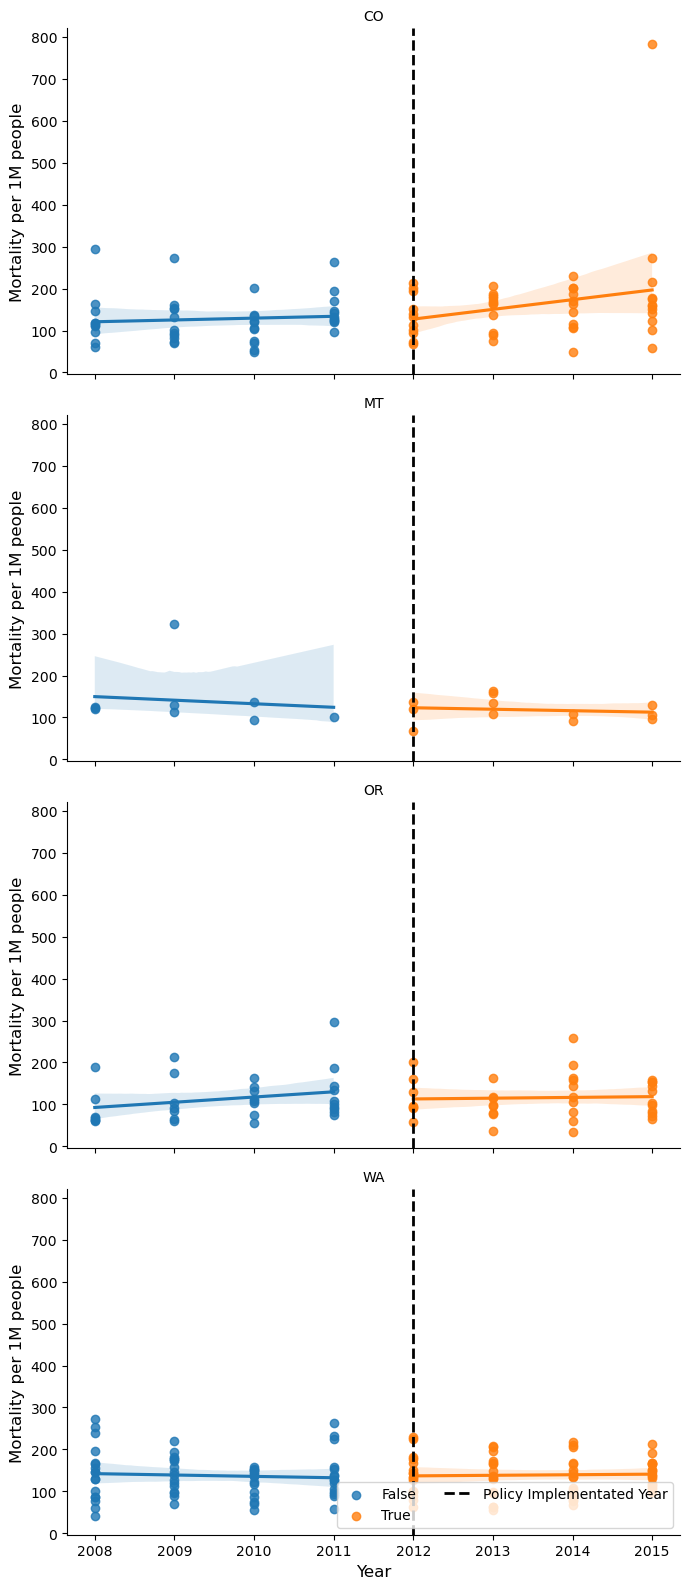

In [14]:
# Calling the all_states_plot function to visualize the data
all_states_plot(mortality_plot, pol_implem_year, "MORM_MORT_MULT")

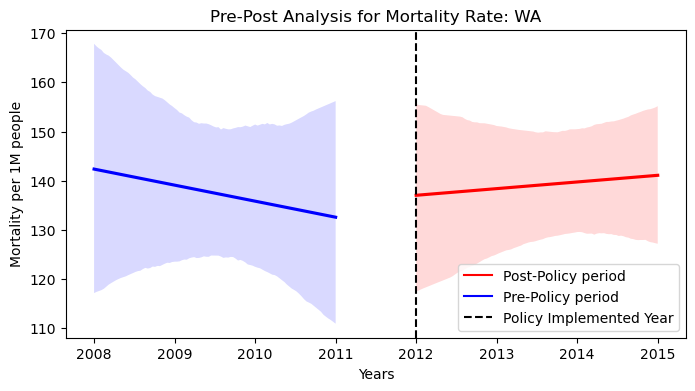

In [15]:
# Calling the pre_post_plot function to visualize pre-post analysis for mortality: WA
pre_post_plot(mortality_plot, testing_state, pol_implem_year, "MORM_MORT_MULT")

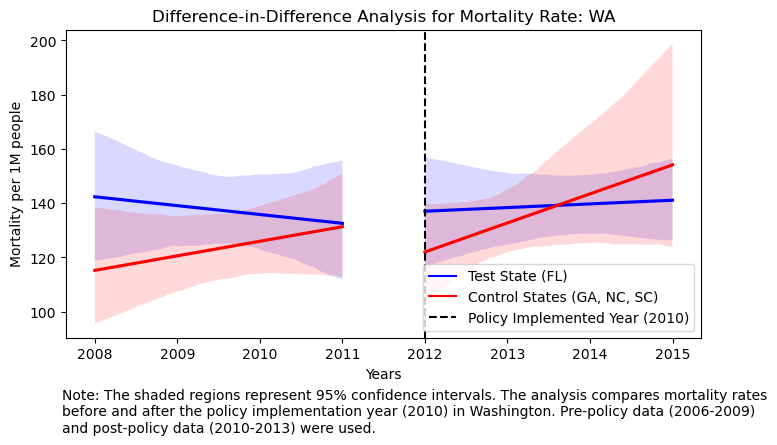

In [16]:
# Calling the dif_dif_plot function to visualize difference-in-difference analysis for mortality: WA

dif_dif_plot(
    mortality_plot, testing_state, controlling_states, pol_implem_year, "MORM_MORT_MULT"
)

### Pre-post Analysis and Difference-in-Difference Analysis for Florida


In [17]:
# Defining the testing state for the analysis
testing_state = "FL"

# Listing of controlling states for comparison
controlling_states = ["GA", "NC", "SC"]

# Defining key years for the analysis
pol_implem_year = 2010
starting_year = 2006
ending_year = 2013

mortality_plot = prepare_data(
    mortality_data,
    testing_state,
    controlling_states,
    pol_implem_year,
    starting_year,
    ending_year,
)

mortality_plot

,STATE_NAME,STATE,COUNTY,COUNTY_CODE,YEAR,POPULATION,DEATHS,MORTALITY_DATA,MORM_MORT_MULT,POLICY_IMPLEMENTATION,STATE_TYPE
133,FLORIDA,FL,ALACHUA COUNTY,12001,2007,242685,17,0.000070,70.049653,False,Test
134,FLORIDA,FL,ALACHUA COUNTY,12001,2009,246657,15,0.000061,60.813194,False,Test
135,FLORIDA,FL,ALACHUA COUNTY,12001,2010,247624,15,0.000061,60.575712,True,Test
136,FLORIDA,FL,ALACHUA COUNTY,12001,2011,249879,14,0.000056,56.027117,True,Test
137,FLORIDA,FL,ALACHUA COUNTY,12001,2012,249879,14,0.000056,56.027117,True,Test
...,...,...,...,...,...,...,...,...,...,...,...
1623,SOUTH CAROLINA,SC,YORK COUNTY,45091,2009,223616,26,0.000116,116.270750,False,Control
1624,SOUTH CAROLINA,SC,YORK COUNTY,45091,2010,226871,24,0.000106,105.786989,True,Control
1625,SOUTH CAROLINA,SC,YORK COUNTY,45091,2011,230131,22,0.000096,95.597725,True,Control
1626,SOUTH CAROLINA,SC,YORK COUNTY,45091,2012,230131,28,0.000122,121.669832,True,Control


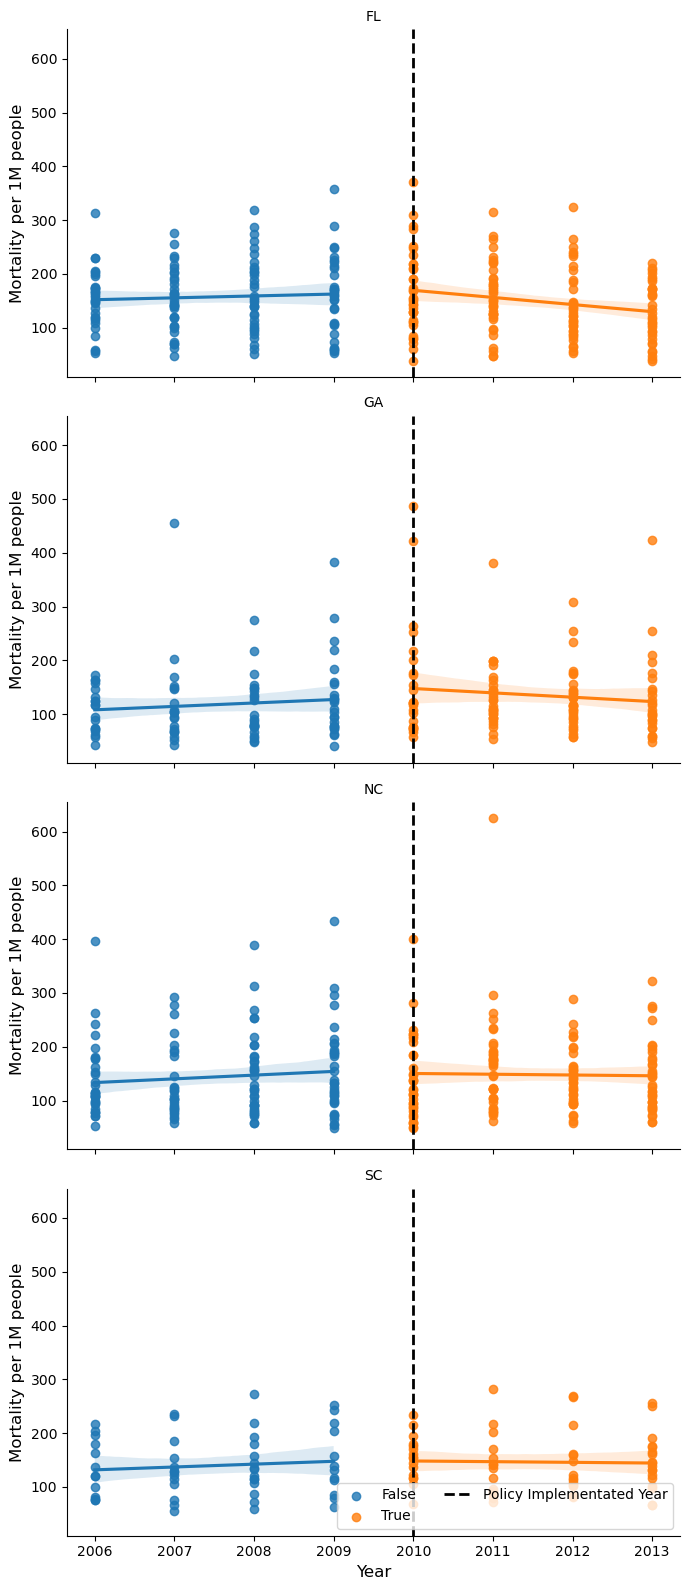

In [18]:
# Calling the all_states_plot function to visualize the data
all_states_plot(mortality_plot, pol_implem_year, "MORM_MORT_MULT")

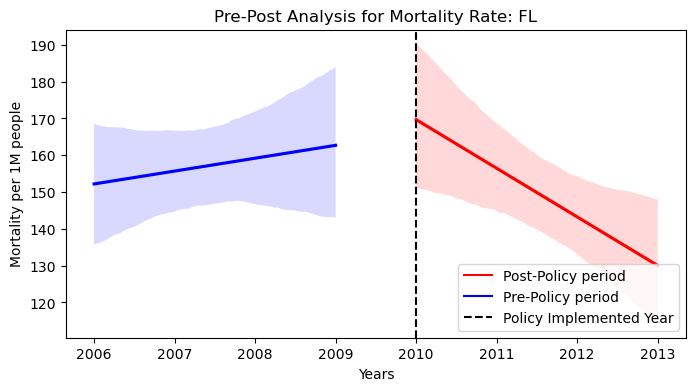

In [19]:
# Calling the pre_post_plot function to visualize pre-post analysis for mortality: FL
pre_post_plot(mortality_plot, testing_state, pol_implem_year, "MORM_MORT_MULT")

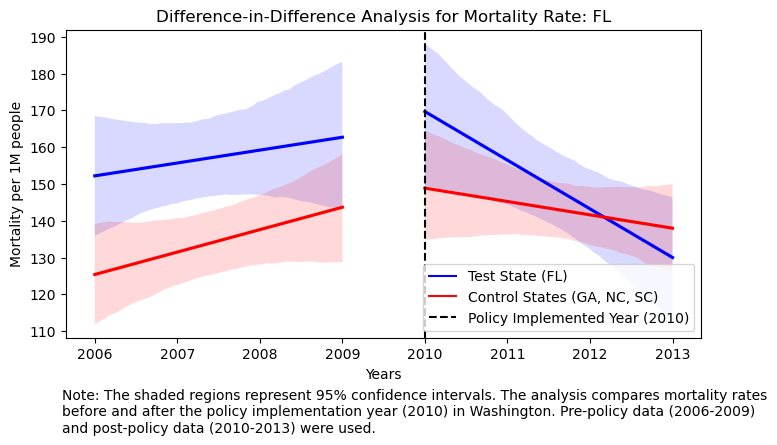

In [20]:
# Calling the dif_dif_plot function to visualize difference-in-difference analysis for mortality: FL
dif_dif_plot(
    mortality_plot, testing_state, controlling_states, pol_implem_year, "MORM_MORT_MULT"
)